# RAPTOR Documentation/Wiki Knowledge Base Demo

This notebook demonstrates hierarchical documentation retrieval using RAPTOR:
1. Scrape documentation websites (recursively follows links)
2. Extract and clean documentation content
3. Apply RAPTOR clustering for multi-level understanding
4. Store embeddings in FAISS vector store
5. Perform semantic search on documentation

**Key Features**:
- Automatic documentation scraping with depth control
- Smart content extraction (removes navigation, footers, etc.)
- Hierarchical summaries: Pages → Sections → Topics → Domain Knowledge
- Preserves documentation structure and links
- Local embeddings (no API costs)

## Setup

**Prerequisites:**
1. Run `uv sync` in project root
2. Copy `.env.example` to `.env` and configure API keys
3. Install required packages for web scraping

In [2]:
import sys
import os
from pathlib import Path
from typing import List, Dict, Set
from urllib.parse import urljoin, urlparse
import time

# Add parent directory to path
sys.path.insert(0, os.path.abspath('..'))

# Remove cached modules
modules_to_remove = [key for key in sys.modules.keys() if key.startswith('src.')]
for module in modules_to_remove:
    del sys.modules[module]

# Import our modules
from src.config import Config
from src.raptor import RAPTORProcessor
from src.vector_store import FAISSVectorStore
from src.docs_scraper import DocumentationScraper

# Import web scraping libraries (for reference, but now handled by docs_scraper)
import requests
from bs4 import BeautifulSoup
import html2text

print("✓ Modules loaded successfully")

✓ Modules loaded successfully


## Documentation Scraper

The `DocumentationScraper` class is imported from `src.docs_scraper`.

**Features:**
- Recursively crawls documentation sites
- Respects robots.txt and rate limits
- Extracts clean content (removes navigation, ads, etc.)
- Preserves document structure and metadata
- HTML to Markdown conversion

## Configuration

Choose LLM provider for summaries: `"openai"` or `"gemini"`

Embeddings use local sentence-transformers (no API calls required)

In [3]:
# Configuration
LLM_PROVIDER = "gemini"  # or "openai"
USE_LOCAL_EMBEDDINGS = True  # Use free local embeddings

# Initialize configuration
config = Config(llm_provider=LLM_PROVIDER, use_local_embeddings=USE_LOCAL_EMBEDDINGS)
print(f"Configuration loaded: {config}")
print(f"Embeddings: {'Local (sentence-transformers)' if USE_LOCAL_EMBEDDINGS else f'{LLM_PROVIDER} API'}")

Configuration loaded: Config(provider=gemini, model=gemini-2.0-flash)
Embeddings: Local (sentence-transformers)


## Set Documentation URL and Parameters

**Popular Documentation Sites to Try:**
- FastAPI: `https://fastapi.tiangolo.com/`
- LangChain: `https://python.langchain.com/docs/get_started/introduction`
- Django: `https://docs.djangoproject.com/en/stable/`
- Flask: `https://flask.palletsprojects.com/`
- Requests: `https://requests.readthedocs.io/en/latest/`

**Parameters:**
- `max_depth`: How many link levels to follow (0=single page, 1=direct links, 2=links of links)
- `max_pages`: Maximum pages to scrape (prevents runaway crawling)
- `delay`: Seconds between requests (be respectful to servers!)

In [5]:
# Documentation URL to scrape
DOCS_URL = "https://fastapi.tiangolo.com/"  # Modify as needed

# Scraping parameters
MAX_DEPTH = 2        # 0=single page, 1=direct links, 2=two levels deep
MAX_PAGES = 30       # Maximum pages to scrape
DELAY = 1.0          # Seconds between requests

# Output directories
CACHE_DIR = "../data/docs_cache"
VECTOR_STORE_DIR = "../data/docs_vector_store"

# Create directories
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(VECTOR_STORE_DIR, exist_ok=True)

print(f"Documentation URL: {DOCS_URL}")
print(f"Max Depth: {MAX_DEPTH}")
print(f"Max Pages: {MAX_PAGES}")
print(f"Cache directory: {CACHE_DIR}")
print(f"Vector store directory: {VECTOR_STORE_DIR}")

Documentation URL: https://fastapi.tiangolo.com/
Max Depth: 2
Max Pages: 30
Cache directory: ../data/docs_cache
Vector store directory: ../data/docs_vector_store


## Step 1: Scrape Documentation

Process:
1. Start from base URL
2. Extract clean content from each page
3. Follow links up to specified depth
4. Respect rate limits and robots.txt

In [6]:
# Initialize scraper
scraper = DocumentationScraper(
    base_url=DOCS_URL,
    max_depth=MAX_DEPTH,
    max_pages=MAX_PAGES,
    delay=DELAY
)

# Scrape documentation
scraped_pages = scraper.scrape()

print(f"\nScraped Pages Summary:")
for i, page in enumerate(scraped_pages[:5], 1):
    print(f"  {i}. {page['title'][:60]}... ({page['length']} chars)")
if len(scraped_pages) > 5:
    print(f"  ... and {len(scraped_pages) - 5} more pages")


🚀 Starting documentation scraper...
   Base URL: https://fastapi.tiangolo.com/
   Max Depth: 2
   Max Pages: 30
   Delay: 1.0s

📄 Scraping: https://fastapi.tiangolo.com/
📄 Scraping: https://fastapi.tiangolo.com/newsletter/
📄 Scraping: https://fastapi.tiangolo.com/newsletter/
📄 Scraping: https://fastapi.tiangolo.com/de/
📄 Scraping: https://fastapi.tiangolo.com/de/
📄 Scraping: https://fastapi.tiangolo.com/es/
📄 Scraping: https://fastapi.tiangolo.com/es/
📄 Scraping: https://fastapi.tiangolo.com/fa/
📄 Scraping: https://fastapi.tiangolo.com/fa/
📄 Scraping: https://fastapi.tiangolo.com/fr/
📄 Scraping: https://fastapi.tiangolo.com/fr/
📄 Scraping: https://fastapi.tiangolo.com/ja/
📄 Scraping: https://fastapi.tiangolo.com/ja/
📄 Scraping: https://fastapi.tiangolo.com/ko/
📄 Scraping: https://fastapi.tiangolo.com/ko/
📄 Scraping: https://fastapi.tiangolo.com/pt/
📄 Scraping: https://fastapi.tiangolo.com/pt/
📄 Scraping: https://fastapi.tiangolo.com/ru/
📄 Scraping: https://fastapi.tiangolo.com/ru/
📄 S

### Inspect Scraped Content

In [7]:
# Show first page content
if scraped_pages:
    sample_page = scraped_pages[0]
    print(f"Title: {sample_page['title']}")
    print(f"URL: {sample_page['url']}")
    print(f"Depth: {sample_page['depth']}")
    print(f"\nContent Preview:\n")
    print(sample_page['content'][:500] + "...")
else:
    print("No pages scraped. Check the URL and parameters.")

Title: FastAPI¶
URL: https://fastapi.tiangolo.com/
Depth: 0

Content Preview:

# FastAPI¶
[](https://fastapi.tiangolo.com)
_FastAPI framework, high performance, easy to learn, fast to code, ready for
production_
[
](https://github.com/fastapi/fastapi/actions?query=workflow%3ATest+event%3Apush+branch%3Amaster)
[ ](https://coverage-badge.samuelcolvin.workers.dev/redirect/fastapi/fastapi)
[ ](https://pypi.org/project/fastapi) [ ](https://pypi.org/project/fastapi)
* * *
**Documentation** : <https://fastapi.tiangolo.com>
**Source Code** : <https://github.com/fastapi/fastapi>
* ...


### Convert to Text Chunks

Prepare documentation pages for RAPTOR processing:

In [8]:
# Convert scraped pages to text chunks with metadata
doc_chunks = []

for page in scraped_pages:
    # Create formatted chunk with metadata
    chunk = f"""# {page['title']}
URL: {page['url']}
Depth: {page['depth']}

{page['content']}
"""
    doc_chunks.append(chunk)

print(f"\nCreated {len(doc_chunks)} documentation chunks")
print(f"Average chunk size: {sum(len(c) for c in doc_chunks) // len(doc_chunks):,} characters")


Created 12 documentation chunks
Average chunk size: 18,358 characters


### Optional: Save Scraped Data

Cache scraped content to avoid re-scraping:

In [9]:
import json
from datetime import datetime

# Save scraped data
cache_file = os.path.join(CACHE_DIR, f"docs_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")

with open(cache_file, 'w', encoding='utf-8') as f:
    json.dump(scraped_pages, f, indent=2, ensure_ascii=False)

print(f"✓ Scraped data saved to: {cache_file}")

✓ Scraped data saved to: ../data/docs_cache/docs_20251031_144809.json


## Step 2: Apply RAPTOR Clustering

RAPTOR creates hierarchical documentation structure:
- **Level 0 (Leaf)**: Individual documentation pages
- **Level 1**: Summaries of related pages (e.g., API endpoints, tutorials)
- **Level 2**: Topic-level summaries (e.g., authentication, deployment)
- **Level 3**: High-level domain knowledge

Enables retrieval at different abstraction levels.

In [10]:
# Initialize RAPTOR processor
raptor = RAPTORProcessor(config)

# Apply RAPTOR clustering (3 levels of hierarchy)
print("Building RAPTOR tree structure...")
print("Creating hierarchical summaries of documentation.\n")

all_doc_texts = raptor.process(texts=doc_chunks, n_levels=3)

print(f"\nRAPTOR Results:")
print(f"  Original documentation pages: {len(doc_chunks)}")
print(f"  Total texts (with summaries): {len(all_doc_texts)}")
print(f"  New summaries created: {len(all_doc_texts) - len(doc_chunks)}")

🔧 Using local embeddings (sentence-transformers/all-MiniLM-L6-v2)


/home/parshav-potato/projects/western_digital_project/demo_code/src/config.py:58: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  return HuggingFaceEmbeddings(


Building RAPTOR tree structure...
Creating hierarchical summaries of documentation.


Building RAPTOR tree with 3 levels...
Starting with 12 leaf texts


/home/parshav-potato/projects/western_digital_project/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Level 1: Generated 2 clusters
  Level 2: Generated 1 clusters
  Level 2: Generated 1 clusters
  Level 1: Added 2 summaries
  Level 2: Added 1 summaries
RAPTOR processing complete: 15 total texts

RAPTOR Results:
  Original documentation pages: 12
  Total texts (with summaries): 15
  New summaries created: 3
  Level 1: Added 2 summaries
  Level 2: Added 1 summaries
RAPTOR processing complete: 15 total texts

RAPTOR Results:
  Original documentation pages: 12
  Total texts (with summaries): 15
  New summaries created: 3


## Step 3: Create FAISS Vector Store

Store documentation chunks and summaries in FAISS for semantic search.

In [11]:
# Initialize vector store
vector_store = FAISSVectorStore(config)

# Create vector store from all texts
print("Creating vector store from documentation embeddings...")
vector_store.create_from_texts(all_doc_texts)

# Display stats
stats = vector_store.get_stats()
print(f"\nVector Store Stats:")
for key, value in stats.items():
    print(f"  {key}: {value}")

🔧 Using local embeddings (sentence-transformers/all-MiniLM-L6-v2)
Creating vector store from documentation embeddings...

Creating FAISS vector store from 15 texts...
Creating vector store from documentation embeddings...

Creating FAISS vector store from 15 texts...
Vector store created successfully

Vector Store Stats:
  status: initialized
  n_vectors: 15
  embedding_provider: gemini
Vector store created successfully

Vector Store Stats:
  status: initialized
  n_vectors: 15
  embedding_provider: gemini


### Save Vector Store

In [13]:
# Save vector store for later use
vector_store.save(VECTOR_STORE_DIR)
print(f"Vector store saved to {VECTOR_STORE_DIR}")


Saving vector store to ../data/docs_vector_store...
Vector store saved successfully
Vector store saved to ../data/docs_vector_store


## Step 4: Semantic Documentation Search

Search documentation using natural language queries.

**Example queries:**
- "How do I get started with authentication?"
- "What are the best practices for deployment?"
- "Show me examples of API endpoints"
- "How to handle errors and exceptions?"

In [14]:
# Example query
query = "How do I get started?"  # Modify as needed

print(f"Query: {query}\n")

# Search for similar documentation
results = vector_store.similarity_search_with_score(query, k=5)

print(f"\nTop {len(results)} Results:\n")
print("=" * 80)
for i, (doc, score) in enumerate(results, 1):
    print(f"\nResult {i} (Similarity Score: {score:.4f}):")
    print("-" * 80)
    # Show first 400 characters
    content_preview = doc.page_content[:400]
    print(content_preview + "..." if len(doc.page_content) > 400 else content_preview)
    print("=" * 80)

Query: How do I get started?


Top 5 Results:


Result 1 (Similarity Score: 1.6924):
--------------------------------------------------------------------------------
FastAPI is a modern, high-performance Python web framework for building APIs. It's designed to be easy to learn and use, enabling faster coding with fewer bugs. Key features include:

*   **Performance:** Comparable to NodeJS and Go, making it one of the fastest Python frameworks.
*   **Development Speed:** Increases feature development speed by 200-300%.
*   **Reduced Errors:** Reduces human-indu...

Result 2 (Similarity Score: 1.7763):
--------------------------------------------------------------------------------
# FastAPI¶
URL: https://fastapi.tiangolo.com/ja/
Depth: 2

# FastAPI¶
[](https://fastapi.tiangolo.com)
_FastAPI framework, high performance, easy to learn, fast to code, ready for
production_
[
](https://github.com/fastapi/fastapi/actions?query=workflow%3ATest+event%3Apush+branch%3Amaster)
[ ](https://coverage

### Multiple Example Queries

Try different types of queries:

In [15]:
# Try multiple queries
example_queries = [
    "How to install and setup?",
    "What are the main features?",
    "Show me configuration options",
    "How to deploy to production?",
]

for query in example_queries:
    print(f"\n{'='*80}")
    print(f"Query: {query}")
    print(f"{'='*80}\n")
    
    results = vector_store.similarity_search_with_score(query, k=2)
    
    for i, (doc, score) in enumerate(results, 1):
        print(f"Result {i} (Score: {score:.4f}):")
        # Show first 200 chars
        preview = doc.page_content[:200].replace('\n', ' ')
        print(f"{preview}...")
        print()


Query: How to install and setup?

Result 1 (Score: 1.7411):
FastAPI is a modern, high-performance Python web framework for building APIs. It's designed to be easy to learn and use, enabling faster coding with fewer bugs. Key features include:  *   **Performanc...

Result 2 (Score: 1.7779):
# FastAPI¶ URL: https://fastapi.tiangolo.com/fr/ Depth: 2  # FastAPI¶ [](https://fastapi.tiangolo.com) _Framework FastAPI, haute performance, facile à apprendre, rapide à coder, prêt pour la productio...


Query: What are the main features?

Result 1 (Score: 1.5849):
FastAPI is a modern, high-performance Python web framework for building APIs. It's designed to be easy to learn and use, enabling faster coding with fewer bugs. Key features include:  *   **Performanc...

Result 2 (Score: 1.6062):
# FastAPI and friends newsletter¶ URL: https://fastapi.tiangolo.com/newsletter/ Depth: 1  # FastAPI and friends newsletter¶ Back to top   *[Completion]: also known as auto-complete, autocompletion, In...


Que

## Advanced: Documentation Context Search

Search with abstraction level awareness:

In [ ]:
def search_docs_with_context(query: str, k: int = 3):
    """
    Search and display results with abstraction level metadata.
    """
    print(f"Query: {query}\n")
    
    results = vector_store.similarity_search_with_score(query, k=k)
    
    for i, (doc, score) in enumerate(results, 1):
        print(f"\nResult {i} (Similarity: {1-score:.3f}):")
        print("-" * 80)
        
        # Determine if it's original doc or summary
        content = doc.page_content
        if "URL:" in content and "Depth:" in content:
            level = "📄 Leaf (Original Page)"
        elif len(content) < 300:
            level = "📚 High-level Summary"
        else:
            level = "📖 Mid-level Summary"
        
        print(f"Level: {level}")
        print(f"\nContent:\n{content[:500]}...")
        print("-" * 80)

# Try it out
search_docs_with_context("What are the core concepts I need to understand?")

## Interactive Documentation Search

Run this cell multiple times with different queries:

In [ ]:
# Interactive search
your_query = "Enter your documentation question here"  # Modify as needed

results = vector_store.similarity_search(your_query, k=3)

print(f"Query: {your_query}\n")
print("=" * 80)

for i, doc in enumerate(results, 1):
    print(f"\nResult {i}:")
    print("-" * 80)
    print(doc.page_content[:600])
    print("=" * 80)

## Optional: Load from Cache

Load previously scraped documentation to skip web scraping:

In [ ]:
# Uncomment to load from cache
# import json

# # List cached files
# cache_files = sorted(Path(CACHE_DIR).glob("docs_*.json"))
# if cache_files:
#     print("Available cache files:")
#     for i, f in enumerate(cache_files, 1):
#         print(f"  {i}. {f.name}")
    
#     # Load most recent
#     with open(cache_files[-1], 'r', encoding='utf-8') as f:
#         scraped_pages = json.load(f)
    
#     print(f"\n✓ Loaded {len(scraped_pages)} pages from cache")
# else:
#     print("No cache files found")

## Optional: Load Existing Vector Store

Load previously saved vector store to skip processing:

In [ ]:
# Uncomment to load existing vector store
# vector_store_loaded = FAISSVectorStore(config)
# vector_store_loaded.load(VECTOR_STORE_DIR)

# print("Vector store loaded successfully")
# print(f"Stats: {vector_store_loaded.get_stats()}")

## Bonus: Documentation Statistics

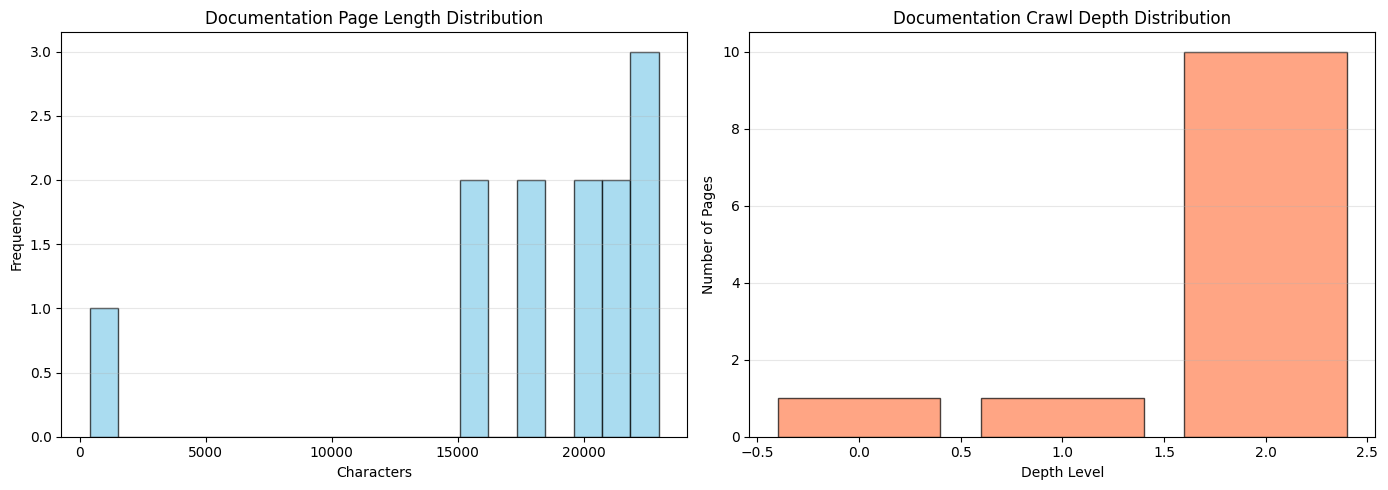


Documentation Statistics:
  Total pages: 12
  Average length: 18296 characters
  Max depth reached: 2
  Total content: 219,553 characters


In [16]:
import matplotlib.pyplot as plt

# Analyze documentation structure
if scraped_pages:
    # Content length distribution
    lengths = [page['length'] for page in scraped_pages]
    depths = [page['depth'] for page in scraped_pages]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Length distribution
    ax1.hist(lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.set_title('Documentation Page Length Distribution')
    ax1.set_xlabel('Characters')
    ax1.set_ylabel('Frequency')
    ax1.grid(axis='y', alpha=0.3)
    
    # Depth distribution
    depth_counts = {d: depths.count(d) for d in set(depths)}
    ax2.bar(depth_counts.keys(), depth_counts.values(), color='coral', edgecolor='black', alpha=0.7)
    ax2.set_title('Documentation Crawl Depth Distribution')
    ax2.set_xlabel('Depth Level')
    ax2.set_ylabel('Number of Pages')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nDocumentation Statistics:")
    print(f"  Total pages: {len(scraped_pages)}")
    print(f"  Average length: {sum(lengths)/len(lengths):.0f} characters")
    print(f"  Max depth reached: {max(depths)}")
    print(f"  Total content: {sum(lengths):,} characters")

## Summary

Successfully completed:
- ✓ Scraped documentation website with smart crawling
- ✓ Extracted clean content with metadata preservation
- ✓ Applied RAPTOR hierarchical clustering
- ✓ Created FAISS vector store for documentation search
- ✓ Performed semantic search on documentation

### Next Steps:

1. **Try different documentation sites** - FastAPI, Django, LangChain, etc.
2. **Adjust scraping parameters** - depth, max_pages, delay
3. **Integrate with chatbot** - Build documentation Q&A assistant
4. **Multi-site indexing** - Combine multiple documentation sources
5. **Custom extractors** - Add support for specific doc site layouts
6. **Continuous updates** - Schedule periodic re-scraping

### Use Cases:

- **Developer Onboarding**: Help new developers find relevant docs quickly
- **Support Automation**: Power chatbots with accurate documentation
- **Knowledge Management**: Index internal wikis and confluence pages
- **API Discovery**: Help developers find relevant API endpoints
- **Code Examples**: Find code snippets and tutorials

### Optimization Tips:

- **Larger sites**: Use `max_pages` limit and increase `delay`
- **Better extraction**: Customize CSS selectors for specific sites
- **Caching**: Save scraped data to avoid re-scraping
- **Incremental updates**: Track changes and only update modified pages
- **Custom embeddings**: Try documentation-specific embedding models